# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_512_3200_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_512_3200_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_512_3200_train3.pkl"


Target_dir_train1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_train1.pkl")
Target_dir_train2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_train2.pkl")
Target_dir_test1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_test1.pkl")
Target_dir_test2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_test2.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_train1.pkl")
Target_cyclegan_dir_train2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_train2.pkl")
Target_cyclegan_dir_test1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_test1.pkl")
Target_cyclegan_dir_test2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_test2.pkl")

In [ ]:
CHANNELS = 3
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

# Loading Dataset

## configuration

In [ ]:
#rescale
def convert(data_list):
    for i in range(len(data_list)): data_list[i]=data_list[i]/255

In [ ]:
# Data Augmentation
def augment(image):
    image = np.array(image, dtype=np.float32)
    #image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

def augment_1(image):
    image = np.array(image, dtype=np.float32)
    image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

# process dataset
def data_augmentation(dataset):
    au=[]
    for file in dataset:
        file_au = augment(file)
        au.append(file_au)
    return au

## LC25000 Data Augmentation Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'][0:533] + LC25000_train2['train'][0:534] + LC25000_train3['train'][0:533] 
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'][0:533],LC25000_train2['train_label'][0:534],LC25000_train3['train_label'][0:533]))
# LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] 
# LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)

### Data Augmentation Process

In [ ]:
LC25000_train_data_au = data_augmentation(LC25000_train_data)

In [ ]:
LC25000_train_data_au = np.array(LC25000_train_data_au, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", LC25000_train_data_au.shape)
print("The shape of LC25000_train_labels: ", LC25000_train_labels.shape)

The shape of LC25000_train_data:  (1600, 512, 512, 3)
The shape of LC25000_train_labels:  (1600,)


In [ ]:
import gc
gc.collect()

125

## TCGA Cyclegan Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train1), "rb") as f:
    TCGA_train1 = pickle.load(f)
with open(os.path.abspath(Target_dir_train2), "rb") as f:
    TCGA_train2 = pickle.load(f)
# with open(os.path.abspath(Target_cyclegan_dir_train1), "rb") as f:
#     TCGA_cyclegan_train1 = pickle.load(f)
# with open(os.path.abspath(Target_cyclegan_dir_train2), "rb") as f:
#     TCGA_cyclegan_train2 = pickle.load(f)
# with open(os.path.abspath(Target_cyclegan_dir_test1), "rb") as f:
#     TCGA_cyclegan_test1 = pickle.load(f)
# with open(os.path.abspath(Target_cyclegan_dir_test2), "rb") as f:
#     TCGA_cyclegan_test2 = pickle.load(f)

In [ ]:
TCGA_cyclegan_train_data = TCGA_train1['train'][0:800] + TCGA_train2['train'][0:800]
TCGA_cyclegan_train_labels = np.concatenate((TCGA_train1['train_label'][0:800],TCGA_train2['train_label'][0:800]))
# TCGA_cyclegan_train_data = TCGA_cyclegan_train1['train'] + TCGA_cyclegan_train2['train']
# TCGA_cyclegan_train_labels = np.concatenate((TCGA_cyclegan_train1['train_label'],TCGA_cyclegan_train2['train_label']))
# TCGA_cyclegan_test_data = TCGA_cyclegan_test1['test'] + TCGA_cyclegan_test2['test']
# TCGA_cyclegan_test_labels = np.concatenate((TCGA_cyclegan_test1['test_label'],TCGA_cyclegan_test2['test_label']))

In [ ]:
TCGA_cyclegan_train_lab = tf.one_hot(TCGA_cyclegan_train_labels, depth=3)
# TCGA_cyclegan_test_lab = tf.one_hot(TCGA_cyclegan_test_labels, depth=3)

In [ ]:
TCGA_cyclegan_train_data = np.array(TCGA_cyclegan_train_data, dtype=np.float32)
# TCGA_cyclegan_test_data = np.array(TCGA_cyclegan_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_cyclegan_train_data: ", TCGA_cyclegan_train_data.shape)
print("The shape of TCGA_cyclegan_train_labels: ", TCGA_cyclegan_train_labels.shape)
# print("The shape of TCGA_cyclegan_test_data: ", TCGA_cyclegan_test_data.shape)
# print("The shape of TCGA_cyclegan_test_labels: " , TCGA_cyclegan_test_labels.shape)

The shape of TCGA_cyclegan_train_data:  (1600, 512, 512, 3)
The shape of TCGA_cyclegan_train_labels:  (1600,)


In [ ]:
import gc
gc.collect()

100

## Datasets Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


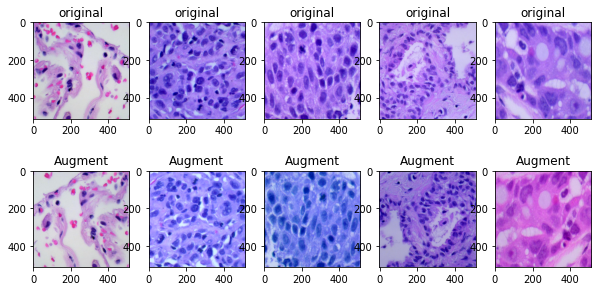

In [ ]:
# show the difference bewteen Original images and Data Augmentation images
fig = plt.figure(figsize=(10, 10))

for i in range(5):
    sample = random.choice(LC25000_train_data)
    fig.add_subplot(2,5,i+1)
    img = array_to_img(sample)
    plt.title("original")
    plt.imshow(img)
    fig.add_subplot(1,5,i+1)
    img1 = augment_1(sample)
    plt.title("Augment")
    plt.imshow(img1)

<function matplotlib.pyplot.show>

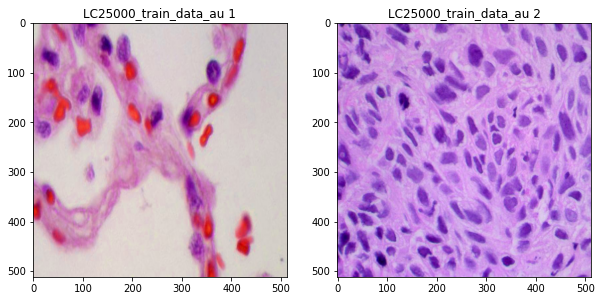

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data_au)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data_au 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_train_data_au)
img2 = array_to_img(sample2)
plt.title("LC25000_train_data_au 2")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

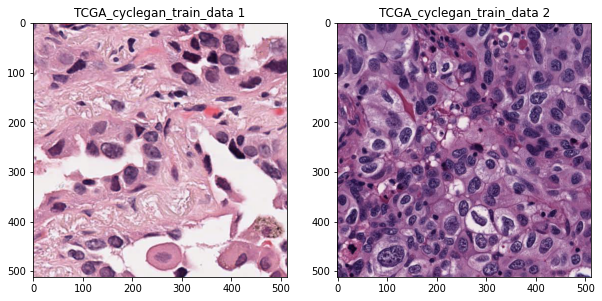

In [ ]:
# random show images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_cyclegan_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_cyclegan_train_data 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_cyclegan_train_data)
img2 = array_to_img(sample2)
plt.title("TCGA_cyclegan_train_data 2")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - ResNet50V2

In [ ]:
resnet50 = ResNet50(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":  # change name
        x = layer([inputs, x])
    else:
        if layer.name == "conv5_block3_preact_bn":
            pass
        else:
            x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_resnet50(path="./Model/DANN_Model/resnet50_last_block_512.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/resnet50_last_block_512.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 16, 204  0           []                               
                                8)]                                                               
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 16, 16, 512)  1049088     ['input_2[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 16, 16, 512)  2048       ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

### Extract the features 

In [ ]:
LC25000_train_data_au_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data_au)))

In [ ]:
gc.collect()

19816

In [ ]:
TCGA_cyclegan_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_cyclegan_train_data)))

In [ ]:
del LC25000_train_data

In [ ]:
gc.collect()

743

In [ ]:
print("LC25000_train_data_au (source) shape: %s"%str(LC25000_train_data_au.shape))
print("TCGA_cyclegan_train_data (target) shape: %s"%str(TCGA_cyclegan_train_data.shape))

LC25000_train_data_au (source) shape: (1600, 512, 512, 3)
TCGA_cyclegan_train_data (target) shape: (1600, 512, 512, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

In [ ]:
import gc
gc.collect()

200

# Fit without adaptation

### Run 1

In [ ]:
lr =  1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=4)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/4
200/200 [==============================] - 8s 30ms/step - loss: 0.9447 - acc: 0.6550 - val_loss: 1.0605 - val_acc: 0.2481
Epoch 2/4
200/200 [==============================] - 5s 23ms/step - loss: 0.6217 - acc: 0.8119 - val_loss: 0.9983 - val_acc: 0.3606
Epoch 3/4
200/200 [==============================] - 6s 29ms/step - loss: 0.4197 - acc: 0.8712 - val_loss: 0.8616 - val_acc: 0.5550
Epoch 4/4
200/200 [==============================] - 5s 27ms/step - loss: 0.3154 - acc: 0.9087 - val_loss: 0.7596 - val_acc: 0.6150
Epoch 1/100
200/200 [==============================] - 11s 37ms/step - loss: 0.2429 - acc: 0.9244 - val_loss: 0.7897 - val_acc: 0.6031
Epoch 2/100
200/200 [==============================] - 6s 31ms/step - loss: 0.2051 - acc: 0.9306 - val_loss: 0.6785 - val_acc: 0.6656
Epoch 3/100
200/200 [==============================] - 6s 30ms/step - loss: 0.1735 - acc: 0.9413 - val_loss: 0.8011 - val_acc: 0.6081
Epoch 4/100
200/200 [==============================] - 6s 31ms/step -

### Run 2

In [ ]:
lr =  1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/3
200/200 [==============================] - 7s 29ms/step - loss: 0.9543 - acc: 0.6263 - val_loss: 1.0990 - val_acc: 0.0812
Epoch 2/3
200/200 [==============================] - 5s 25ms/step - loss: 0.6338 - acc: 0.7850 - val_loss: 0.9448 - val_acc: 0.4794
Epoch 3/3
200/200 [==============================] - 5s 25ms/step - loss: 0.4267 - acc: 0.8675 - val_loss: 0.7905 - val_acc: 0.6256
Epoch 1/80
200/200 [==============================] - 11s 40ms/step - loss: 0.2995 - acc: 0.9119 - val_loss: 0.6984 - val_acc: 0.6662
Epoch 2/80
200/200 [==============================] - 6s 31ms/step - loss: 0.2368 - acc: 0.9175 - val_loss: 0.7118 - val_acc: 0.6506
Epoch 3/80
200/200 [==============================] - 6s 32ms/step - loss: 0.1998 - acc: 0.9262 - val_loss: 0.6461 - val_acc: 0.6900
Epoch 4/80
200/200 [==============================] - 7s 33ms/step - loss: 0.1774 - acc: 0.9312 - val_loss: 0.6533 - val_acc: 0.6913
Epoch 5/80
200/200 [==============================] - 7s 33ms/step - lo

### Run 3

In [ ]:
lr =  1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/3
200/200 [==============================] - 7s 30ms/step - loss: 0.9606 - acc: 0.6050 - val_loss: 1.0782 - val_acc: 0.1194
Epoch 2/3
200/200 [==============================] - 4s 22ms/step - loss: 0.6380 - acc: 0.7937 - val_loss: 0.9908 - val_acc: 0.4144
Epoch 3/3
200/200 [==============================] - 5s 24ms/step - loss: 0.4274 - acc: 0.8650 - val_loss: 0.8599 - val_acc: 0.5600
Epoch 1/80
200/200 [==============================] - 10s 38ms/step - loss: 0.3047 - acc: 0.9094 - val_loss: 0.6667 - val_acc: 0.6800
Epoch 2/80
200/200 [==============================] - 6s 30ms/step - loss: 0.2378 - acc: 0.9169 - val_loss: 0.6208 - val_acc: 0.7069
Epoch 3/80
200/200 [==============================] - 6s 30ms/step - loss: 0.2007 - acc: 0.9269 - val_loss: 0.6365 - val_acc: 0.6931
Epoch 4/80
200/200 [==============================] - 6s 30ms/step - loss: 0.1744 - acc: 0.9388 - val_loss: 0.6638 - val_acc: 0.6862
Epoch 5/80
200/200 [==============================] - 6s 30ms/step - lo

### Run 4

In [ ]:
lr =  1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/3
200/200 [==============================] - 7s 30ms/step - loss: 0.9763 - acc: 0.6350 - val_loss: 1.1286 - val_acc: 0.0581
Epoch 2/3
200/200 [==============================] - 4s 22ms/step - loss: 0.6692 - acc: 0.7837 - val_loss: 1.0229 - val_acc: 0.3550
Epoch 3/3
200/200 [==============================] - 5s 26ms/step - loss: 0.4367 - acc: 0.8737 - val_loss: 0.8195 - val_acc: 0.6169
Epoch 1/80
200/200 [==============================] - 10s 38ms/step - loss: 0.3121 - acc: 0.9075 - val_loss: 0.6829 - val_acc: 0.6900
Epoch 2/80
200/200 [==============================] - 6s 31ms/step - loss: 0.2395 - acc: 0.9237 - val_loss: 0.6533 - val_acc: 0.7013
Epoch 3/80
200/200 [==============================] - 6s 31ms/step - loss: 0.1939 - acc: 0.9375 - val_loss: 0.6279 - val_acc: 0.7069
Epoch 4/80
200/200 [==============================] - 6s 31ms/step - loss: 0.1729 - acc: 0.9400 - val_loss: 0.7048 - val_acc: 0.6812
Epoch 5/80
200/200 [==============================] - 6s 31ms/step - lo

### Run 5

In [ ]:
lr =  1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/3
200/200 [==============================] - 7s 29ms/step - loss: 0.9804 - acc: 0.6194 - val_loss: 1.1411 - val_acc: 0.0219
Epoch 2/3
200/200 [==============================] - 5s 25ms/step - loss: 0.6659 - acc: 0.7900 - val_loss: 1.0369 - val_acc: 0.3038
Epoch 3/3
200/200 [==============================] - 4s 22ms/step - loss: 0.4389 - acc: 0.8694 - val_loss: 0.9066 - val_acc: 0.5113
Epoch 1/80
200/200 [==============================] - 11s 40ms/step - loss: 0.3117 - acc: 0.9013 - val_loss: 0.6904 - val_acc: 0.6762
Epoch 2/80
200/200 [==============================] - 7s 33ms/step - loss: 0.2433 - acc: 0.9181 - val_loss: 0.6302 - val_acc: 0.7075
Epoch 3/80
200/200 [==============================] - 7s 33ms/step - loss: 0.1955 - acc: 0.9369 - val_loss: 0.6541 - val_acc: 0.6963
Epoch 4/80
200/200 [==============================] - 7s 33ms/step - loss: 0.1642 - acc: 0.9438 - val_loss: 0.7616 - val_acc: 0.6338
Epoch 5/80
200/200 [==============================] - 7s 33ms/step - lo

### Result

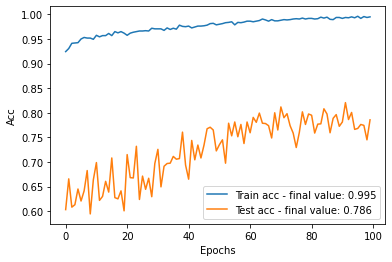

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


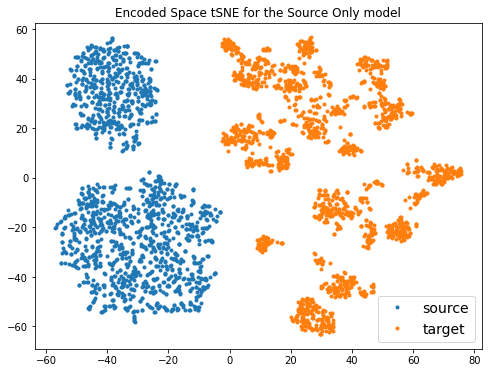

In [ ]:
LC25000_train_data_au_enc = finetunig.transform(LC25000_train_data_au_ex)
TCGA_cyclegan_train_data_enc = finetunig.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_cyclegan_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.066131,0.976525,1.011800,0.726031
std,0.043438,0.016011,0.128864,0.061809
min,0.014534,0.924375,0.678522,0.594375
25%,0.031706,0.966250,0.926367,0.670469
50%,0.057391,0.980625,1.016315,0.744375
75%,0.089203,0.990156,1.092790,0.777031
max,0.242902,0.996250,1.342155,0.820625


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_512/MDD_source_512_Resnet_RMS_1e-6_AU_cyclegan.csv")

# Fit with adaptation

### Run 1

In [ ]:
lr =  1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
200/200 [==============================] - 14s 51ms/step - loss: 0.9549 - acc: 0.6075 - disc_loss: 1.4986 - val_loss: 0.7692 - val_acc: 0.9812
Epoch 2/150
200/200 [==============================] - 9s 43ms/step - loss: 0.6030 - acc: 0.8119 - disc_loss: 1.4250 - val_loss: 0.6805 - val_acc: 0.8794
Epoch 3/150
200/200 [==============================] - 9s 47ms/step - loss: 0.3789 - acc: 0.8687 - disc_loss: 1.3739 - val_loss: 0.4808 - val_acc: 0.8906
Epoch 4/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2589 - acc: 0.9087 - disc_loss: 1.3269 - val_loss: 0.4900 - val_acc: 0.8288
Epoch 5/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2180 - acc: 0.9269 - disc_loss: 1.2729 - val_loss: 0.4460 - val_acc: 0.8281
Epoch 6/150
200/200 [==============================] - 9s 43ms/step - loss: 0.1675 - acc: 0.9444 - disc_loss: 1.2128 - val_loss: 0.4418 - val_acc: 0.8156
Epoch 7/150
200/200 [==============================] - 9s 43ms/step - loss:

### Run 2

In [ ]:
lr =  1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
200/200 [==============================] - 15s 55ms/step - loss: 0.9371 - acc: 0.6294 - disc_loss: 1.4536 - val_loss: 0.8135 - val_acc: 0.9588
Epoch 2/150
200/200 [==============================] - 9s 44ms/step - loss: 0.6130 - acc: 0.7969 - disc_loss: 1.4100 - val_loss: 0.7403 - val_acc: 0.8419
Epoch 3/150
200/200 [==============================] - 9s 43ms/step - loss: 0.3937 - acc: 0.8619 - disc_loss: 1.3640 - val_loss: 0.5443 - val_acc: 0.8544
Epoch 4/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2778 - acc: 0.9031 - disc_loss: 1.3311 - val_loss: 0.4481 - val_acc: 0.8438
Epoch 5/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2102 - acc: 0.9231 - disc_loss: 1.2687 - val_loss: 0.4305 - val_acc: 0.8206
Epoch 6/150
200/200 [==============================] - 9s 43ms/step - loss: 0.1888 - acc: 0.9344 - disc_loss: 1.1939 - val_loss: 0.4142 - val_acc: 0.8338
Epoch 7/150
200/200 [==============================] - 9s 43ms/step - loss:

### Run 3




In [ ]:
lr =  1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
200/200 [==============================] - 15s 55ms/step - loss: 0.9487 - acc: 0.6331 - disc_loss: 1.4878 - val_loss: 0.7699 - val_acc: 0.9875
Epoch 2/150
200/200 [==============================] - 9s 44ms/step - loss: 0.6261 - acc: 0.7987 - disc_loss: 1.4288 - val_loss: 0.7494 - val_acc: 0.8631
Epoch 3/150
200/200 [==============================] - 9s 43ms/step - loss: 0.4055 - acc: 0.8631 - disc_loss: 1.3905 - val_loss: 0.6453 - val_acc: 0.7831
Epoch 4/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2760 - acc: 0.9062 - disc_loss: 1.3589 - val_loss: 0.4847 - val_acc: 0.8400
Epoch 5/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2113 - acc: 0.9281 - disc_loss: 1.2892 - val_loss: 0.4637 - val_acc: 0.8225
Epoch 6/150
200/200 [==============================] - 9s 43ms/step - loss: 0.1915 - acc: 0.9300 - disc_loss: 1.2403 - val_loss: 0.4606 - val_acc: 0.8131
Epoch 7/150
200/200 [==============================] - 9s 43ms/step - loss:

### Run 4

In [ ]:
lr =  1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
200/200 [==============================] - 14s 53ms/step - loss: 0.9411 - acc: 0.6350 - disc_loss: 1.4614 - val_loss: 0.7847 - val_acc: 0.9744
Epoch 2/150
200/200 [==============================] - 9s 44ms/step - loss: 0.6057 - acc: 0.8025 - disc_loss: 1.4292 - val_loss: 0.7032 - val_acc: 0.8788
Epoch 3/150
200/200 [==============================] - 9s 43ms/step - loss: 0.3878 - acc: 0.8644 - disc_loss: 1.3750 - val_loss: 0.5684 - val_acc: 0.8487
Epoch 4/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2810 - acc: 0.9000 - disc_loss: 1.3301 - val_loss: 0.4506 - val_acc: 0.8519
Epoch 5/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2123 - acc: 0.9231 - disc_loss: 1.2749 - val_loss: 0.4365 - val_acc: 0.8406
Epoch 6/150
200/200 [==============================] - 9s 43ms/step - loss: 0.1800 - acc: 0.9425 - disc_loss: 1.2097 - val_loss: 0.4025 - val_acc: 0.8531
Epoch 7/150
200/200 [==============================] - 9s 43ms/step - loss:

### Run 5

In [ ]:
lr =  1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
200/200 [==============================] - 14s 54ms/step - loss: 0.9478 - acc: 0.6306 - disc_loss: 1.4859 - val_loss: 0.8519 - val_acc: 0.9156
Epoch 2/150
200/200 [==============================] - 9s 44ms/step - loss: 0.6080 - acc: 0.8225 - disc_loss: 1.4348 - val_loss: 0.6746 - val_acc: 0.8850
Epoch 3/150
200/200 [==============================] - 9s 43ms/step - loss: 0.3863 - acc: 0.8587 - disc_loss: 1.3885 - val_loss: 0.5489 - val_acc: 0.8550
Epoch 4/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2679 - acc: 0.9087 - disc_loss: 1.3457 - val_loss: 0.5260 - val_acc: 0.7975
Epoch 5/150
200/200 [==============================] - 9s 44ms/step - loss: 0.2143 - acc: 0.9269 - disc_loss: 1.2932 - val_loss: 0.3838 - val_acc: 0.8550
Epoch 6/150
200/200 [==============================] - 9s 43ms/step - loss: 0.1860 - acc: 0.9306 - disc_loss: 1.2336 - val_loss: 0.4573 - val_acc: 0.8031
Epoch 7/150
200/200 [==============================] - 9s 44ms/step - loss:

### Result

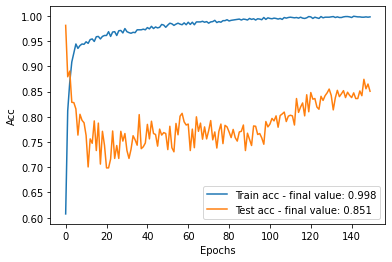

In [ ]:
acc = mdd_1.history.history["acc"]; val_acc = mdd_1.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


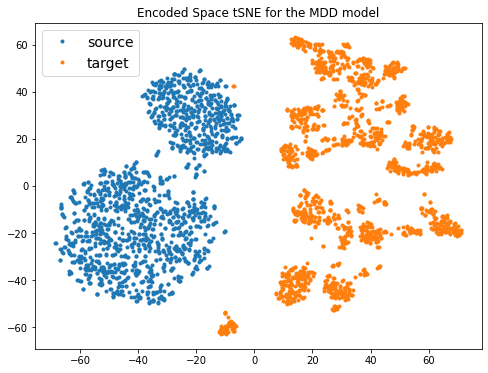

In [ ]:
LC25000_train_data_enc = mdd_1.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = mdd_1.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd_1.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.061076,0.978913,0.372196,0.903342,0.787829
std,0.100598,0.038763,0.292925,0.234853,0.044144
min,0.005333,0.607500,0.040622,0.441792,0.698750
25%,0.015641,0.972813,0.167177,0.743616,0.756719
50%,0.034848,0.989062,0.263432,0.890317,0.783437
75%,0.075604,0.996250,0.483512,1.063958,0.815469
max,0.954950,0.999375,1.458849,1.494105,0.981250


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_512/MDD_Resnet_512_RMS_1e-6_g1_AU_cyclegan.csv")

In [ ]:
import gc
gc.collect()

4091